<a href="https://colab.research.google.com/github/DiogoMonteiro99/repos/blob/main/casas_boston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Casas em Boston Regressão linear**

###Importando as bibliotecas

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statistics as sts
import warnings
from scipy.stats import probplot,shapiro,spearmanr,pearsonr,kendalltau
from statsmodels import stats
from statsmodels.stats.diagnostic import lilliefors
import statsmodels
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from google.cloud import bigquery


warnings.filterwarnings('ignore')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/housing.csv')

**Entendendo as colunas**

RM: É o número médio de cômodos entre os imoveis no bairro.

LSTAT: É a porcentagem de proprietários no bairro considerados de "classe baixa" (proletariado)

PTRATIO: É a razão entre estudantes e professores nas escolas de ensino fundamental e médio no bairro.

**Coluna alvo**

MEDV: Valor médio das casas        

In [101]:
class Analisar():
    def __init__(self,dados):
        self.df = dados
    def analise(self):
        for i in self.df.columns:
            if self.df[i].dtype == 'int64' or self.df[i].dtype == 'float64':
                print(f'\n Nome da coluna:\n {self.df[i].name}')
                print(f'\n Tipo da coluna:\n {self.df[i].dtype}')
                print(f'\n Tipo da coluna:\n {self.df.corr()}')
                print(f'\n Valor media da coluna:\n {round(self.df[i].mean(),2)}')
                print(f'\n Quantidade de linhas da coluna:\n {self.df[i].shape}')
                print(f'\n Valores unicos da coluna:\n {self.df[i].isnull().sum()}')
                print(f'\n Valores nulos da coluna:\n {self.df[i].describe()}')
                fig = px.box(self.df[i])
                fig.update_layout(xaxis=dict(showgrid=False),yaxis=dict(showgrid=False),title=f'Boxplot da coluna {i}',template='plotly_dark')
                fig.show()
    def dispersao(self):
        for e in self.df.columns:
          fig1 = px.scatter(self.df,x=self.df[e],y=self.df.MEDV,title='Correlação Linear',template='plotly_dark')
          fig1.show()

Analise = Analisar(df)
Analise.dispersao()

In [102]:
Analise.analise()


 Nome da coluna:
 RM

 Tipo da coluna:
 float64

 Tipo da coluna:
                RM     LSTAT   PTRATIO      MEDV
RM       1.000000 -0.612033 -0.304559  0.697209
LSTAT   -0.612033  1.000000  0.360445 -0.760670
PTRATIO -0.304559  0.360445  1.000000 -0.519034
MEDV     0.697209 -0.760670 -0.519034  1.000000

 Valor media da coluna:
 6.24

 Quantidade de linhas da coluna:
 (489,)

 Valores unicos da coluna:
 0

 Valores nulos da coluna:
 count    489.000000
mean       6.240288
std        0.643650
min        3.561000
25%        5.880000
50%        6.185000
75%        6.575000
max        8.398000
Name: RM, dtype: float64



 Nome da coluna:
 LSTAT

 Tipo da coluna:
 float64

 Tipo da coluna:
                RM     LSTAT   PTRATIO      MEDV
RM       1.000000 -0.612033 -0.304559  0.697209
LSTAT   -0.612033  1.000000  0.360445 -0.760670
PTRATIO -0.304559  0.360445  1.000000 -0.519034
MEDV     0.697209 -0.760670 -0.519034  1.000000

 Valor media da coluna:
 12.94

 Quantidade de linhas da coluna:
 (489,)

 Valores unicos da coluna:
 0

 Valores nulos da coluna:
 count    489.000000
mean      12.939632
std        7.081990
min        1.980000
25%        7.370000
50%       11.690000
75%       17.120000
max       37.970000
Name: LSTAT, dtype: float64



 Nome da coluna:
 PTRATIO

 Tipo da coluna:
 float64

 Tipo da coluna:
                RM     LSTAT   PTRATIO      MEDV
RM       1.000000 -0.612033 -0.304559  0.697209
LSTAT   -0.612033  1.000000  0.360445 -0.760670
PTRATIO -0.304559  0.360445  1.000000 -0.519034
MEDV     0.697209 -0.760670 -0.519034  1.000000

 Valor media da coluna:
 18.52

 Quantidade de linhas da coluna:
 (489,)

 Valores unicos da coluna:
 0

 Valores nulos da coluna:
 count    489.000000
mean      18.516564
std        2.111268
min       12.600000
25%       17.400000
50%       19.100000
75%       20.200000
max       22.000000
Name: PTRATIO, dtype: float64



 Nome da coluna:
 MEDV

 Tipo da coluna:
 float64

 Tipo da coluna:
                RM     LSTAT   PTRATIO      MEDV
RM       1.000000 -0.612033 -0.304559  0.697209
LSTAT   -0.612033  1.000000  0.360445 -0.760670
PTRATIO -0.304559  0.360445  1.000000 -0.519034
MEDV     0.697209 -0.760670 -0.519034  1.000000

 Valor media da coluna:
 454342.94

 Quantidade de linhas da coluna:
 (489,)

 Valores unicos da coluna:
 0

 Valores nulos da coluna:
 count    4.890000e+02
mean     4.543429e+05
std      1.653403e+05
min      1.050000e+05
25%      3.507000e+05
50%      4.389000e+05
75%      5.187000e+05
max      1.024800e+06
Name: MEDV, dtype: float64


In [103]:
fig = px.scatter_matrix(df,dimensions=["RM", "LSTAT", "PTRATIO", "MEDV"])
fig.update_layout(height=800,width=800,title='Correlação Linear',template='plotly_dark')
fig.show()

# **Análise da Normalidade**

Gráfico QQ-Plot

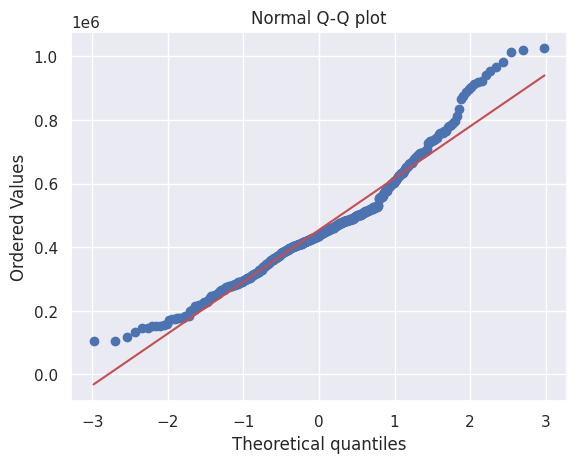

In [104]:
probplot(df.MEDV,dist='norm',plot=plt)
plt.style.use('dark_background')
plt.title('Normal Q-Q plot')
plt.show()

In [105]:
df.columns

Index(['RM', 'LSTAT', 'PTRATIO', 'MEDV'], dtype='object')

In [106]:
fig1 = px.histogram(df,x='MEDV',nbins=50,template='plotly_dark')
fig1.update_layout(title_text='Média dos valores')
fig1.show()

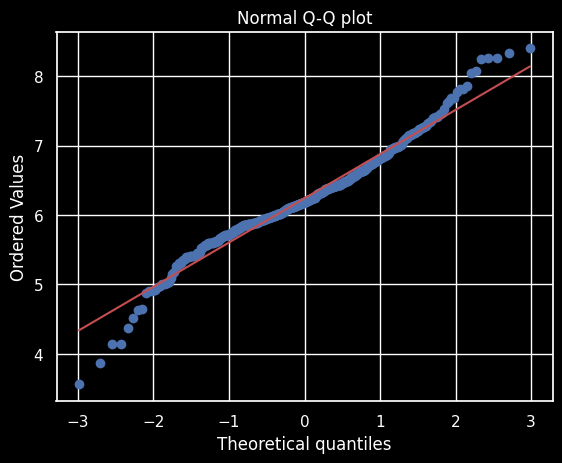

In [107]:
probplot(df.RM,dist='norm',plot=plt)
plt.style.use('dark_background')
plt.title('Normal Q-Q plot')
plt.show()

In [108]:
fig2 = px.histogram(df,x='RM',nbins=60,template='plotly_dark')
fig2.update_layout(title_text='Média dos quartos')
fig2.show()

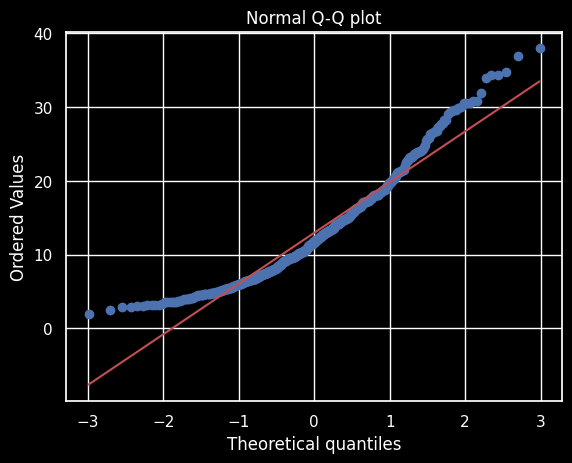

In [109]:
probplot(df.LSTAT,dist='norm',plot=plt)
plt.style.use('dark_background')
plt.title('Normal Q-Q plot')
plt.show()

In [110]:
fig3 = px.histogram(df,x='LSTAT', nbins=40,template='plotly_dark')
fig3.update_layout(title_text='Porcentagem de moradores de classe baixa')
fig3.show()

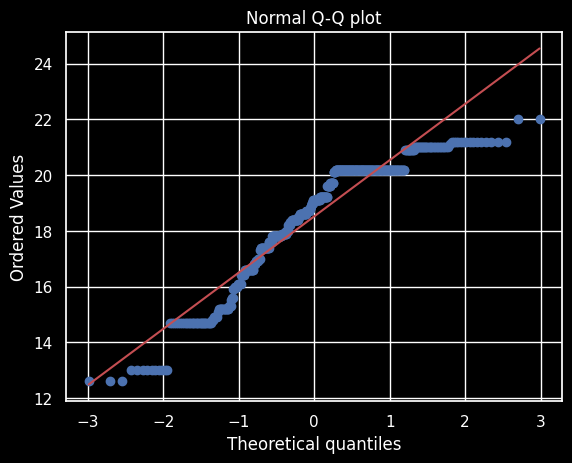

In [111]:
probplot(df.PTRATIO,dist='norm',plot=plt)
plt.style.use('dark_background')
plt.title('Normal Q-Q plot')
plt.show()

In [112]:
fig4 = px.histogram(df,x='PTRATIO',nbins=60,template='plotly_dark')
fig4.update_layout(title_text='Razão entre estudante e professores')
fig4.show()

##Teste de Shapiro-Wilk
Shapiro-Wilk pode ser usado no maximo 5000 linhas

Ho = distribuição normal: p > 0.05

Ha = distribuição != normal: p <= 0.05

In [113]:
shapiro(df.MEDV)

ShapiroResult(statistic=0.9596619009971619, pvalue=2.5762864064304836e-10)

In [114]:
estatistica,p =shapiro(df.MEDV)
print('Shapiro-Wilk')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Shapiro-Wilk
Estatisca do teste: 0.96
P-valor: 2.5762864064304836e-10


In [115]:
estatistica,p =shapiro(df.RM)
print('Shapiro-Wilk')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Shapiro-Wilk
Estatisca do teste: 0.97
P-valor: 2.7085933496096004e-08


In [116]:
estatistica,p =shapiro(df.LSTAT)
print('Shapiro-Wilk')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Shapiro-Wilk
Estatisca do teste: 0.94
P-valor: 1.6900520425407878e-13


In [117]:
estatistica,p =shapiro(df.PTRATIO)
print('Shapiro-Wilk')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Shapiro-Wilk
Estatisca do teste: 0.91
P-valor: 9.07583957756611e-17


## **Resultado:**
###Não a distribuição normal

--------

# **Teste lilliefors (Kolmogorov_Sminov)**
##Lilliefors pode ser usado com mais de 5000 linhas

Ho = distribuição normal: p > 0.05

Ha = distribuição normal: p<= 0.05

In [118]:
estatistica,p =statsmodels.stats.diagnostic.lilliefors(df.MEDV,dist='norm')
print('Lilliefors')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Lilliefors
Estatisca do teste: 0.11
P-valor: 0.0009999999999998899


In [119]:
estatistica,p =statsmodels.stats.diagnostic.lilliefors(df.RM,dist='norm')
print('Lilliefors')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Lilliefors
Estatisca do teste: 0.06
P-valor: 0.0009999999999998899


In [120]:
estatistica,p =statsmodels.stats.diagnostic.lilliefors(df.LSTAT,dist='norm')
print('Lilliefors')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Lilliefors
Estatisca do teste: 0.09
P-valor: 0.0009999999999998899


In [121]:
estatistica,p =statsmodels.stats.diagnostic.lilliefors(df.PTRATIO,dist='norm')
print('Lilliefors')
print(f'Estatisca do teste: {round(estatistica,2)}')
print(f'P-valor: {p}')

Lilliefors
Estatisca do teste: 0.18
P-valor: 0.0009999999999998899


## **Resultado:**
###Confirmação que não a distribuição normal

--------

# **Correlação Linear**
##Pearson (distribuição normal)

##Spearman (distribuição não normal)

##Kendall (distribuição não normal com quantidade pequena de amostras)

Ho = Não há correlação linear: p > 0.05

Ha = existe correlação linear: p <= 0.05

###**Pearson**

In [122]:
coef,p = pearsonr(df.MEDV,df.RM)
print('Pearson')
print(f'Coeficiente de correlação: {coef}')
print(f'p-valor: {p}')

Pearson
Coeficiente de correlação: 0.6972092210185156
p-valor: 2.0533141149513303e-72


### **Spearman**

In [123]:
coef,p = spearmanr(df.MEDV,df.RM)
print('Spearman')
print(f'Coeficiente de correlação: {coef}')
print(f'p-valor: {p}')

Spearman
Coeficiente de correlação: 0.6240572939087418
p-valor: 3.845028634343325e-54


### **Kendall**

In [124]:
coef,p = kendalltau(df.MEDV,df.RM)
print('Kendall')
print(f'Coeficiente de correlação: {coef}')
print(f'p-valor: {p}')

Kendall
Coeficiente de correlação: 0.4724931551110662
p-valor: 9.983146011545424e-55


In [125]:
correlacoes = df.corr(method='spearman')
correlacoes

,RM,LSTAT,PTRATIO,MEDV
RM,1.000000,-0.624700,-0.282053,0.624057
LSTAT,-0.624700,1.000000,0.461739,-0.845527
PTRATIO,-0.282053,0.461739,1.000000,-0.559276
MEDV,0.624057,-0.845527,-0.559276,1.000000


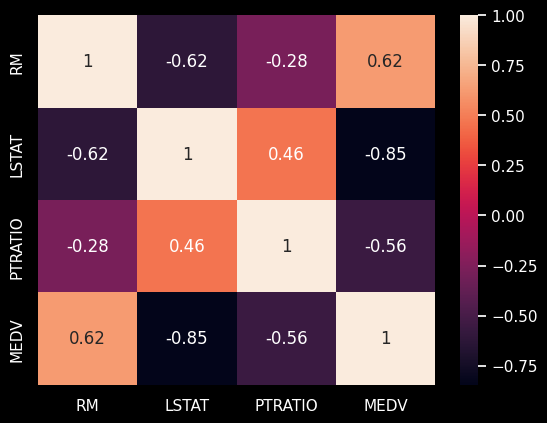

In [126]:
plt.figure()
sns.heatmap(correlacoes,annot=True)
sns.set_theme(style='darkgrid')

# **Regressão Linear Simples**

##Valor médio (MEDV) em função do número de cômodos (RM)

In [127]:
df.head(2)

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0


### Separando a coluna LSTAT

In [128]:
x1 = df.iloc[:,0:1].values
x1

array([[6.575],
       [6.421],
       [7.185],
       [6.998],
       [7.147],
       [6.43 ],
       [6.012],
       [6.172],
       [5.631],
       [6.004],
       [6.377],
       [6.009],
       [5.889],
       [5.949],
       [6.096],
       [5.834],
       [5.935],
       [5.99 ],
       [5.456],
       [5.727],
       [5.57 ],
       [5.965],
       [6.142],
       [5.813],
       [5.924],
       [5.599],
       [5.813],
       [6.047],
       [6.495],
       [6.674],
       [5.713],
       [6.072],
       [5.95 ],
       [5.701],
       [6.096],
       [5.933],
       [5.841],
       [5.85 ],
       [5.966],
       [6.595],
       [7.024],
       [6.77 ],
       [6.169],
       [6.211],
       [6.069],
       [5.682],
       [5.786],
       [6.03 ],
       [5.399],
       [5.602],
       [5.963],
       [6.115],
       [6.511],
       [5.998],
       [5.888],
       [7.249],
       [6.383],
       [6.816],
       [6.145],
       [5.927],
       [5.741],
       [5.966],
       [

### Separando as colunas alvo

In [129]:
y = df.iloc[:,3].values
y

array([ 504000.,  453600.,  728700.,  701400.,  760200.,  602700.,
        480900.,  569100.,  346500.,  396900.,  315000.,  396900.,
        455700.,  428400.,  382200.,  417900.,  485100.,  367500.,
        424200.,  382200.,  285600.,  411600.,  319200.,  304500.,
        327600.,  291900.,  348600.,  310800.,  386400.,  441000.,
        266700.,  304500.,  277200.,  275100.,  283500.,  396900.,
        420000.,  441000.,  518700.,  646800.,  732900.,  558600.,
        531300.,  518700.,  445200.,  405300.,  420000.,  348600.,
        302400.,  407400.,  413700.,  430500.,  525000.,  491400.,
        396900.,  743400.,  518700.,  663600.,  489300.,  411600.,
        392700.,  336000.,  466200.,  525000.,  693000.,  493500.,
        407400.,  462000.,  365400.,  438900.,  508200.,  455700.,
        478800.,  491400.,  506100.,  449400.,  420000.,  436800.,
        445200.,  426300.,  588000.,  501900.,  520800.,  480900.,
        501900.,  558600.,  472500.,  466200.,  495600.,  6027

### Separando os dados em teste e treino

In [166]:
x_treino,x_teste,y_treino,y_teste = train_test_split(x1,y, test_size=0.3, random_state=10,)

In [167]:
x_treino.shape,y_treino.shape

((342, 1), (342,))

In [168]:
x_teste.shape,y_teste.shape

((147, 1), (147,))

In [169]:
reg_linear1 = LinearRegression()
reg_linear1.fit(x_treino,y_treino)

LinearRegression()

### Intercepto (coeficiente linear)

In [170]:
reg_linear1.intercept_

-626510.2699464143

### Coeficiente Angular

In [171]:
reg_linear1.coef_

array([173771.45170999])

###**Equação: Valor = -626510.26 + 173771.45 vezes o número cômodos**

### Coeficiente de Determinação dados de treino

In [172]:
reg_linear1.score(x_treino,y_treino)

0.46368351515551953

In [173]:
reg_linear1.score(x_teste,y_teste)

0.5426573915930195

In [174]:
previsoes_treino = reg_linear1.predict(x_treino)
previsoes_treino

array([551833.94409904, 468423.64727824, 647755.78544295, 658182.07254555,
       586414.46298932, 464600.67534062, 395265.86610833, 229487.901177  ,
       441141.52935977, 424980.78435074, 523161.65456689, 432105.41387085,
       555135.60168153,  44768.84800928, 504915.65213734, 424285.6985439 ,
       565735.66023583, 607962.12300136, 455912.10275512, 442531.70097345,
       505784.50939589, 450003.87339698, 410210.21095539, 390226.49400874,
       472767.93357099, 809884.54988837, 401174.09546647, 639762.29866429,
       465817.07550259, 491882.79325909, 437318.55742215, 416813.52612037,
       413164.32563446, 560870.05958796, 396134.72336688, 459561.30324103,
       335488.4867201 , 521423.94004979, 441315.30081148, 630899.95462708,
       452262.90226921, 557915.94490889, 437144.78597044, 391616.66562242,
       525420.68343912, 459735.07469274, 397872.43788398, 492925.42196935,
       387619.92223309, 533240.39876607, 487538.50696634, 608483.43735649,
       832822.38151409, 4

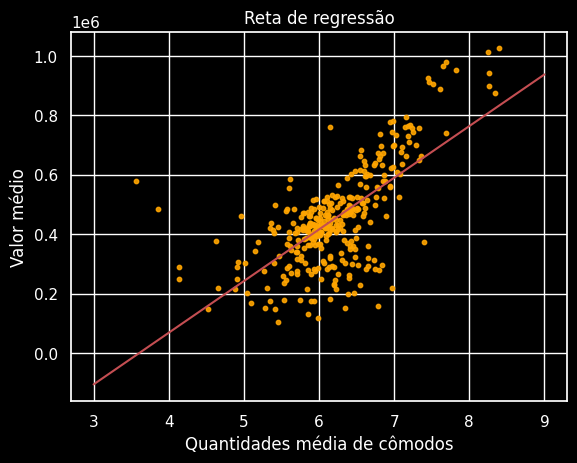

In [182]:
plt.scatter(y=y_treino,x=x_treino,color='orange', s=10, alpha=0.9)
x_plot = np.linspace(3,9)
plt.plot(x_plot,x_plot*reg_linear1.coef_ + reg_linear1.intercept_,color='r')
plt.style.use('dark_background')
plt.title('Reta de regressão')
plt.ylabel('Valor médio')
plt.xlabel('Quantidades média de cômodos')
plt.show()

In [180]:
previsoes_teste = reg_linear1.predict(x_teste)
previsoes_teste

array([419593.86934773, 438187.4146807 , 447744.84452475, 480935.19180136,
       491013.93600054, 494836.90793816, 563650.40281531, 438187.4146807 ,
       500745.1372963 , 482151.59196333, 452436.67372092, 452784.21662434,
       585719.37718248, 394744.5517532 , 321239.22767988, 442705.47242516,
       458171.13162735, 446702.21581449, 442357.92952174, 488581.1356766 ,
       592322.69234746, 244432.24602406, 412816.78273104, 540365.02828618,
       421331.58386483, 554092.97297127, 470856.44760218, 369373.91980354,
       732382.48242572, 411947.92547249, 484758.16373898, 514646.8534331 ,
       565561.88878412, 438534.95758412, 661483.73012804, 452957.98807605,
       579984.91927605, 402911.80998357, 351475.46027742, 537063.37070369,
       491535.25035567, 490145.07874199, 637503.26979206, 512735.36746429,
       722825.05258167, 631768.81188563, 489971.30729028, 353039.40334281,
       471551.53340902, 466512.16130943, 446007.13000765, 384492.03610231,
       390747.80836387, 3

In [179]:
y_teste

array([ 487200.,  428400.,  525000.,  483000.,  516600.,  462000.,
        592200.,  476700.,  512400.,  275100.,  487200.,  518700.,
        501900.,  499800.,  319200.,  621600.,  483000.,  445200.,
        373800.,  273000.,  644700.,  321300.,  510300.,  478800.,
        348600.,  462000.,  516600.,  405300.,  919800.,  266700.,
        455700.,  499800.,  627900.,  357000.,  665700.,  373800.,
        867300.,  327600.,  327600.,  501900.,  151200.,  499800.,
        726600.,  625800.,  835800.,  686700.,  338100.,  300300.,
        499800.,  493500.,  569100.,  220500.,  226800.,  411600.,
        478800.,  241500.,  655200.,  432600.,  441000.,  405300.,
        462000.,  252000.,  495600.,  577500.,  512400.,  392700.,
        279300.,  480900.,  497700.,  554400.,  399000.,  369600.,
        315000.,  445200.,  585900.,  105000.,  388500.,  453600.,
        312900.,  336000.,  315000.,  501900.,  323400.,  476700.,
        382200.,  609000.,  390600.,  413700.,  426300.,  2835

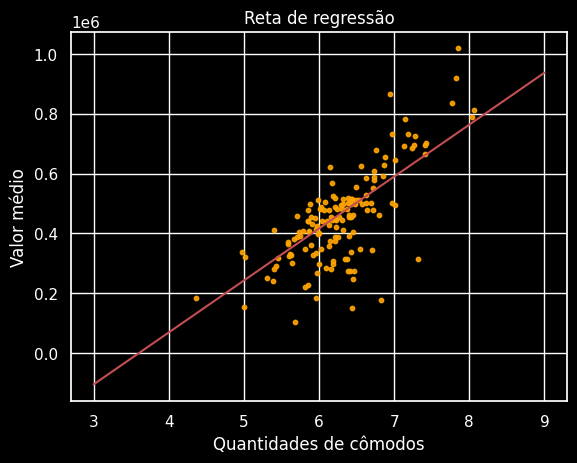

In [181]:
plt.scatter(y=y_teste,x=x_teste, color='orange', s=10, alpha=0.9)
x_plot = np.linspace(3,9)
plt.plot(x_plot,x_plot*reg_linear1.coef_ + reg_linear1.intercept_,color='r')
plt.style.use('dark_background')
plt.title('Reta de regressão')
plt.ylabel('Valor médio')
plt.xlabel('Quantidades de cômodos')
plt.show()

### Fazendo previsões para valores distintos

In [183]:
valor_casa =reg_linear1.predict([[9]])
valor_casa

array([937432.79544351])

## **Resposta:**

###Coeficiente esta muito baixo, isso esta causando erro na previsão dos valores das casas.

###Esta dando erro nas previsão de casas com 1 à 3 quartos.
------------

# **Métricas de Desempenho**

### Erro absoluto

In [184]:
abs(y_teste - previsoes_teste).mean()

76063.99733079868

### Erro médio absoluto

In [185]:
mean_absolute_error(y_teste,previsoes_teste)

76063.99733079868

### Erro quadrádico médio

In [186]:
mean_squared_error(y_teste,previsoes_teste)

11294624525.740473

### Raiz do erro quadrático médio

In [187]:
np.sqrt(mean_squared_error(y_teste,previsoes_teste))

106276.17101561607

### **Valor médio (MEDV) em função da classe social (LSTAT)**

In [188]:
df.head(2)

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0


In [189]:
x2 = df.iloc[:,1:2].values

In [190]:
y = df.iloc[:,3].values

In [191]:
x_treino,x_teste,y_treino,y_teste = train_test_split(x2,y,test_size=0.3,random_state=10)


In [192]:
x_treino.shape,y_treino.shape

((342, 1), (342,))

In [193]:
x_teste.shape,y_teste.shape

((147, 1), (147,))

In [154]:
reg_linear2 = LinearRegression()
reg_linear2.fit(x_treino,y_treino)

LinearRegression()

### Intercepto (coeficinte linear)

In [155]:
reg_linear2.intercept_

681977.7451055486

### Coeficiente Angular

In [156]:
reg_linear2.coef_

array([-17263.75010515])

### **Equação: Valor = 683187.41 - 17660.54 . LSTAT**

### Coeficiente de Determinacão dados de treino

In [157]:
reg_linear2.score(x_treino,y_treino)

0.5688289563355992

### Previsão

In [158]:
previsoes_treino1 = reg_linear2.predict(x_treino)
previsoes_treino1

array([549564.78179906, 401787.080899  , 547493.13178645, 392982.56834537,
       594968.4445756 , 475330.65634693, 474294.83134062, 172179.20450053,
       525050.25664975, 358109.79313297, 527812.45666658, 386940.25580857,
       595141.08207665, 451851.95620393, 590825.14455037, 383660.14328859,
       624489.45725541, 543004.55675911, 413526.4309705 , 422676.21852623,
       572180.29443681, 457548.99373862, 507095.9565404 , 397643.78087376,
       492594.40645207, 610505.81967024, 365533.20567819, 611541.64467654,
       527639.81916553, 401959.71840005, 578740.51947676, 435624.03110509,
       370021.78070552, 342054.50553518, 530229.3816813 , 587027.11952723,
       274553.24262406, 554743.90683061, 563548.41938423, 562339.95687687,
       420086.65601045, 613785.93219021, 536271.6942181 , 515555.19409192,
       280250.28015875, 437005.1311135 , 499672.54399519, 541105.54424754,
       359836.16814349, 475158.01884588, 422676.21852623, 533336.85670022,
       579948.98198412, 5

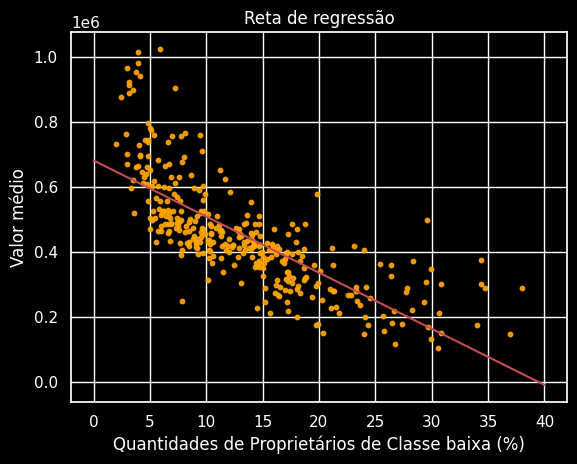

In [159]:
plt.scatter(y=y_treino,x=x_treino, color='orange', s=10, alpha=0.9)
x_plot = np.linspace(0,40)
plt.plot(x_plot,x_plot*reg_linear2.coef_ + reg_linear2.intercept_,color='r')
plt.style.use('dark_background')
plt.title('Reta de regressão')
plt.ylabel('Valor médio')
plt.xlabel('Quantidades de Proprietários de Classe baixa (%)')
plt.show()

In [160]:
# Prevendo os dados de teste
previsoes_teste = reg_linear2.predict(x_teste)
previsoes_teste

array([507441.2315425 , 438731.50612401, 518490.0316098 , 500708.36900149,
       594277.8945714 , 539897.08174018, 551981.70681378, 483789.89389845,
       580121.61948518, 272999.50511459, 558714.56935479, 553535.44432325,
       584610.19451251, 472395.81882905, 370194.41820658, 454959.43122285,
       496565.06897626, 474122.19383957, 363288.91816452, 348614.73057514,
       426646.88105041, 472741.09383115, 480855.05638057, 506578.04403724,
       357419.24312877, 570108.64442419, 573388.75694417, 447018.10617448,
       620346.15723017, 353793.85560668, 452887.78121023, 521770.14412977,
       562512.59437792, 420949.84351571, 591343.05705352, 378135.74325494,
       602737.13212292, 400578.61839164, 394536.30585483, 558024.01935059,
       180465.804551  , 557678.74434848, 567691.71940947, 603255.04462607,
       551463.79431063, 587199.75702829, 474294.83134062, 365360.56817713,
       490350.11893841, 601356.03211451, 351376.93059196, 300276.23028073,
       271273.13010408, 4

In [161]:
# Analisando o score
reg_linear2.score(x_teste,y_teste)

0.6006038196307664

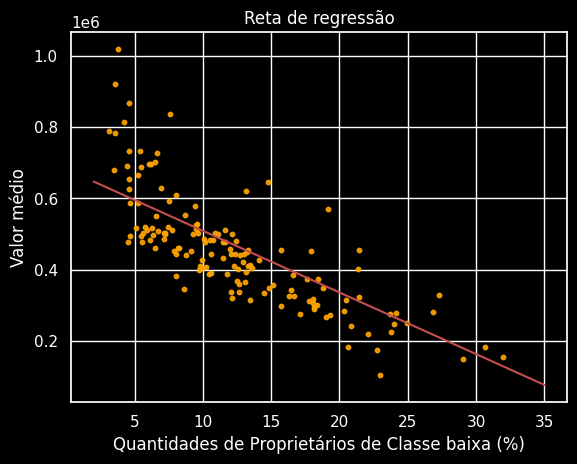

In [162]:
plt.scatter(y=y_teste,x=x_teste, color='orange', s=10, alpha=0.9)
x_plot = np.linspace(2,35)
plt.plot(x_plot,x_plot*reg_linear2.coef_ + reg_linear2.intercept_,color='r')
plt.style.use('dark_background')
plt.title('Reta de regressão')
plt.ylabel('Valor médio')
plt.xlabel('Quantidades de Proprietários de Classe baixa (%)')
plt.show()

In [163]:
# Fazendo previsões para valores distintos
valor_casa = reg_linear2.predict([[32]])
valor_casa

array([129537.74174081])

### Métricas de Desempenho

In [164]:
abs(y_teste - previsoes_teste).mean()

76340.55192245146

In [165]:
# Erro médio absoluto
mean_absolute_error(y_teste, previsoes_teste)

76340.55192245146